In [1]:
# default_exp solar

# Solar System Generation

Based on [this tutorial](https://www.youtube.com/watch?v=XSgerkCVbFc&ab_channel=TheBuffED)

<br>

### Imports

In [2]:
#exports
import cairo
from cairosvg import svg2png

import math
import random

import PIL
from PIL.PngImagePlugin import PngImageFile
from io import BytesIO

from genart import svg

In [3]:
from IPython import display

<br>

### Graphic Components

#### Background

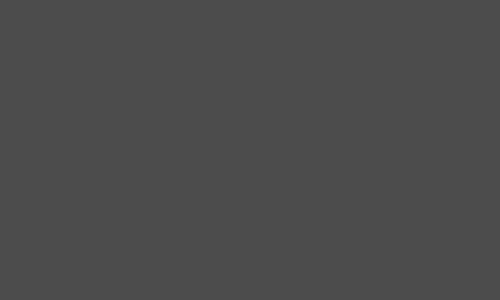

In [4]:
draw_ops = [(
    svg.draw_background, 
    {
        'width': 500,
        'height': 300,
        'bkg_r': 0.3,
        'bkg_g': 0.3,
        'bkg_b': 0.3
    }
)]

svgio = svg.draw_img(draw_ops)

svg.vis_graphic(svgio)

<br>

#### Sun

In [5]:
#exports
def draw_sun(context, width, height, border_size, sun_size, sun_r=243/255, sun_g=156/255, sun_b=18/255):
    sun_center = height - border_size
    svg.draw_circle_fill(context, width/2, sun_center, sun_size, sun_r, sun_g, sun_b)

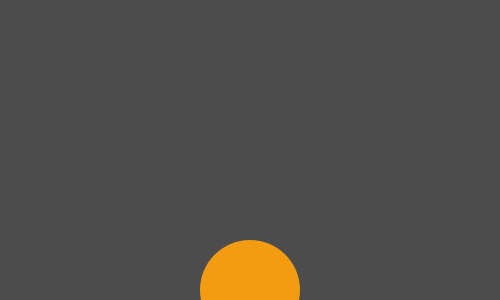

In [6]:
draw_ops += [(
    draw_sun, 
    {
        'width': 500,
        'height': 300,
        'border_size': 10,
        'sun_size': 50
    }
)]

svgio = svg.draw_img(draw_ops)

svg.vis_graphic(svgio)

<br>

#### Planets

In [7]:
#exports
def select_new_colour(old_colour=(145, 185, 141)):
    list_of_colors = [(145, 185, 141), (229, 192, 121), (210, 191, 88), (140, 190, 178), (189, 190, 220),
                      (221, 79, 91), (16, 182, 98), (227, 146, 80), (241, 133, 123), (110, 197, 233), (235, 205, 188), (197, 239, 247), 
                      (190, 144, 212), (41, 241, 195), (101, 198, 187), (255, 246, 143), (189, 195, 199), (243, 241, 239)]
    
    new_colour = random.choice(list_of_colors)

    if old_colour is not None:
        old_colour = tuple([c*255 for c in old_colour])
        
        while (new_colour is old_colour):
            new_colour = random.choice(list_of_colors)

    r, g, b = new_colour[0]/255.0, new_colour[1]/255.0, new_colour[2]/255.0
    
    return r, g, b

In [8]:
#exports
def draw_orbit_path(context, x, y, radius, r, g, b, line_width=1):
    context.set_source_rgb(r, g, b)
    context.set_line_width(line_width)
    context.arc(x, y, radius, 0, 2*math.pi)
    context.stroke()
    
def draw_line_path(context, width, border_size, next_center, r, g, b, line_width=1):
    context.set_source_rgb(r, g, b)
    context.set_line_width(line_width)
    context.move_to(border_size * 2, next_center)
    context.line_to(width-(border_size*2), next_center)
    context.stroke()

In [9]:
#exports
def get_planet_size_center(last_center, last_size, distance_between_planets, min_planet_size=5, max_planet_size=70):
    next_size = random.randint(min_planet_size, max_planet_size)
    next_center = last_center - last_size - (next_size * 2) - distance_between_planets
    
    return next_size, next_center

def draw_planets(context, width, height, border_size, sun_size, distance_between_planets, min_planet_size, max_planet_size, planet_path='orbit', old_colour=None):
    last_center = sun_center = height - border_size
    last_size = sun_size

    for x in range(1, 20):
        next_size, next_center = get_planet_size_center(last_center, last_size, 
                                                        distance_between_planets, 
                                                        min_planet_size, max_planet_size)

        reached_border = (next_center - next_size) < border_size

        if not reached_border:
            # Drawing the planet paths
            r, g, b = select_new_colour(old_colour)
            
            if planet_path == 'orbit': 
                draw_orbit_path(context, width/2, sun_center, height - next_center - border_size, r, g, b),
            elif planet_path == 'line': 
                draw_line_path(context, width, border_size, next_center, r, g, b)
            
            # Drawing the planet
            r, g, b = select_new_colour(old_colour)
            svg.draw_circle_fill(context, width/2, next_center, next_size, r, g, b)

            # Preparing params for next planet
            last_center = next_center
            last_size = next_size

            min_planet_size += 5
            max_planet_size += 5 * x

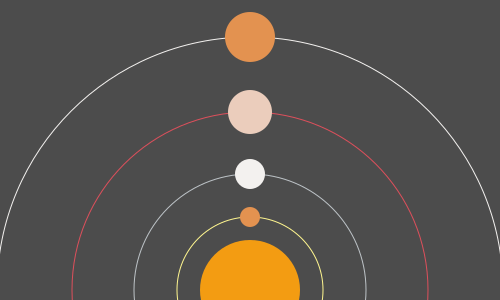

In [10]:
draw_ops += [(
    draw_planets, 
    {
        'width': 500,
        'height': 300,
        'border_size': 10,
        'sun_size': 50,
        'distance_between_planets': 3,
        'min_planet_size': 10,
        'max_planet_size': 10,
        'planet_path': 'orbit'
    }
)]

svgio = svg.draw_img(draw_ops)

svg.vis_graphic(svgio)

<br>

#### Border

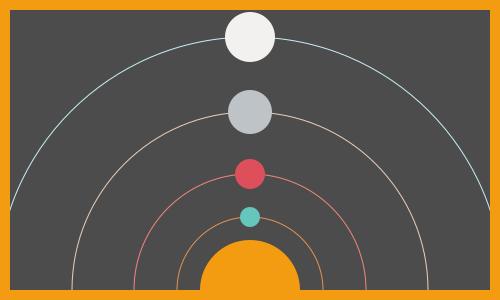

In [11]:
draw_ops += [(
    svg.draw_border, 
    {
        'border_size': 10, 
        'width': 500,
        'height': 300
    }
)]
svgio = svg.draw_img(draw_ops)

svg.vis_graphic(svgio)

<br>

### Adding Noise

Whilst the positioning of the different elements is starting to look alright the texture is a bit too flat, in this step we'll add some roughness by introducing random noise.

In [12]:
#exports
import numpy as np
def add_noise(svgio, dpi=250, global_noise=0.1):
    with BytesIO() as f:
        # Writing the svg data as a png to file object
        svg2png(bytestring=svgio.getvalue(), write_to=f, dpi=dpi)
        
        # Reading the file object with PIL and loading the pixels
        img = PIL.Image.open(f, 'r')
        pixels = img.load()
        
        # Adding noise to the image
        float_gen = lambda a, b: random.uniform(a, b)
        
        for i in range(img.size[0]):
            for j in range(img.size[1]):
                r, g, b = pixels[i, j]

                local_noise = float_gen(1.0 - global_noise, 1.0 + global_noise)
                pixels[i, j] = (int(r*local_noise), int(g*local_noise), int(b*local_noise))
        
        ## !!! Should just create a norm dist numpy array and multiply !!!
        ## img_matrix = np.asarray(img.getdata())
        ## print(img_matrix.shape)

    return img

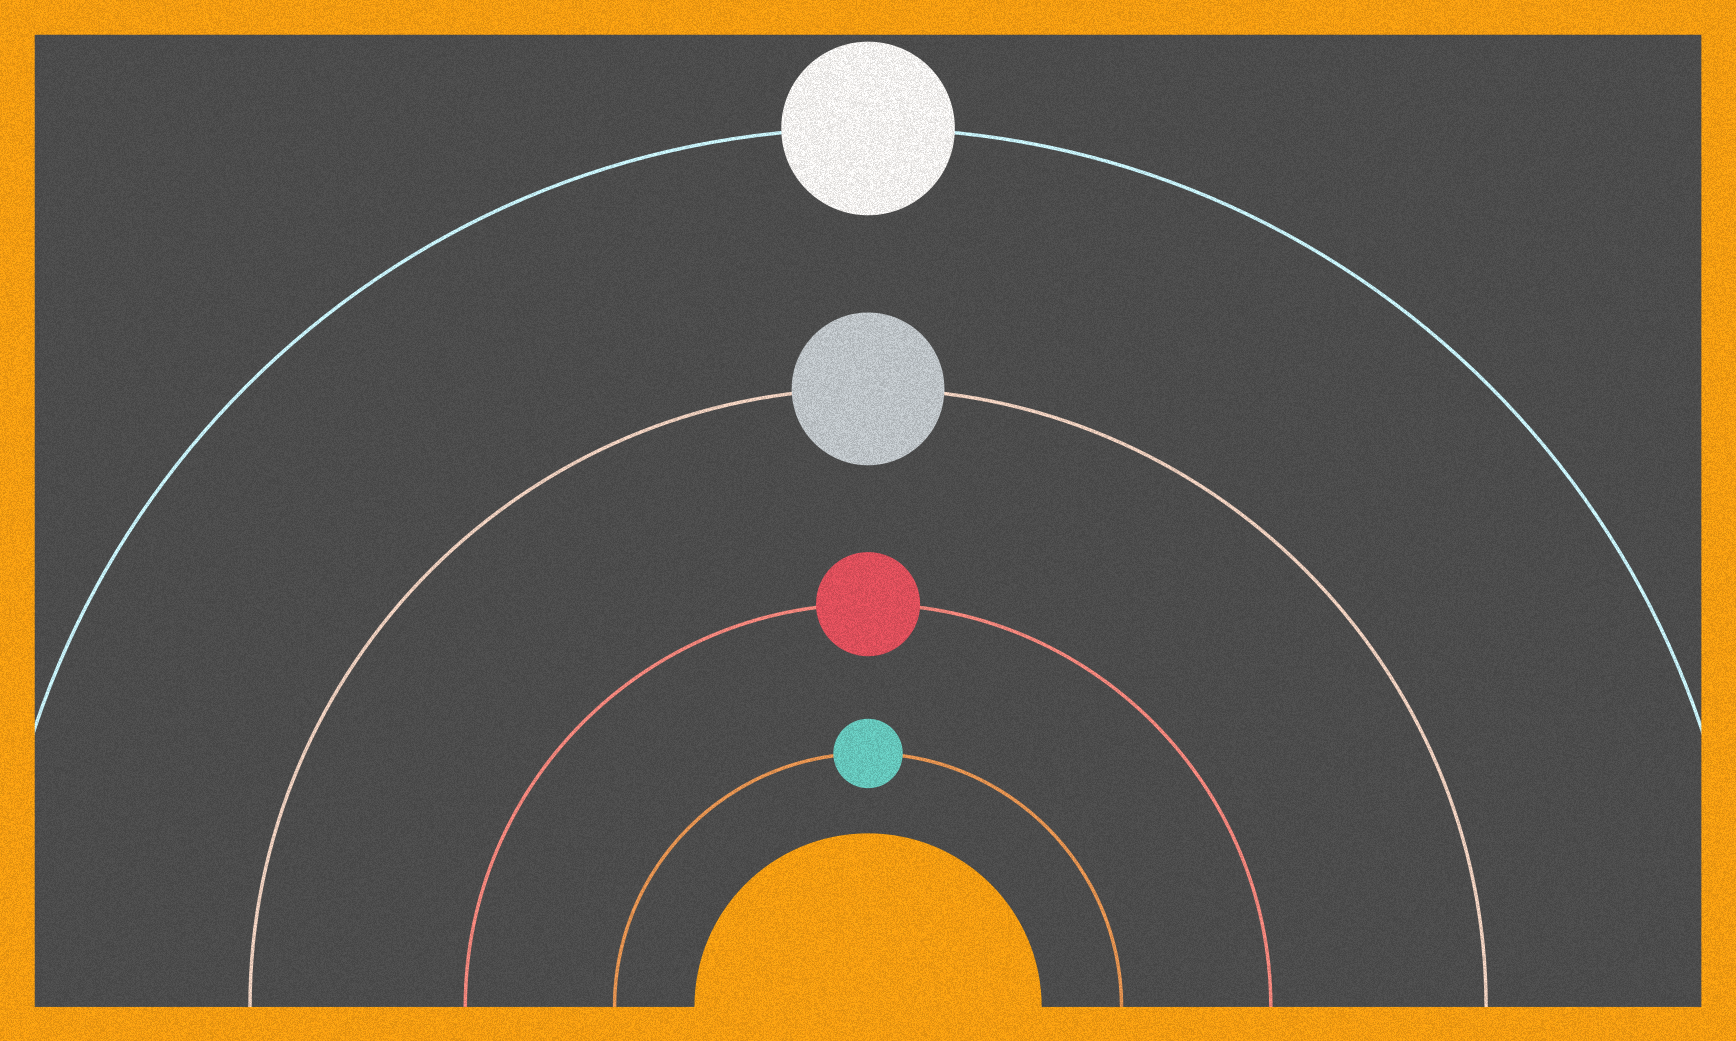

In [13]:
img = add_noise(svgio)
svg.vis_graphic(img)

<br>

### Drawing Wrapper

We'll now create a wrapper function that carries out the entire process that we've just developed

In [16]:
#exports
def draw_solar_system(width=500, height=300, border_size=10, 
                      sun_size=50, distance_between_planets=3, 
                      min_planet_size=3, max_planet_size=10, 
                      bdr_r=243/255, bdr_g=156/255, bdr_b=18/255,
                      bkg_r=0.3, bkg_g=0.3, bkg_b=0.3, planet_path='orbit', 
                      noisen_image=True, dpi=250, global_noise=0.1):
    
    draw_ops = [
        (svg.draw_background, {
            'width': width,
            'height': height,
            'bkg_r': bkg_r,
            'bkg_g': bkg_g,
            'bkg_b': bkg_b
        }),
        (draw_sun, {
            'width': width,
            'height': height,
            'border_size': border_size,
            'sun_size': sun_size
        }),
        (draw_planets, {
            'width': width,
            'height': height,
            'border_size': border_size,
            'sun_size': sun_size,
            'distance_between_planets': distance_between_planets,
            'min_planet_size': min_planet_size,
            'max_planet_size': max_planet_size,
            'planet_path': 'orbit'
        }),
        (svg.draw_border, {
            'width': width,
            'height': height,
            'border_size': border_size,
            'bdr_r': bdr_r, 
            'bdr_g': bdr_g, 
            'bdr_b': bdr_b
        })
    ]

    img = svg.draw_img(draw_ops)
    
    if noisen_image == True:
        img = add_noise(img, dpi=dpi, global_noise=global_noise)
        
    return img

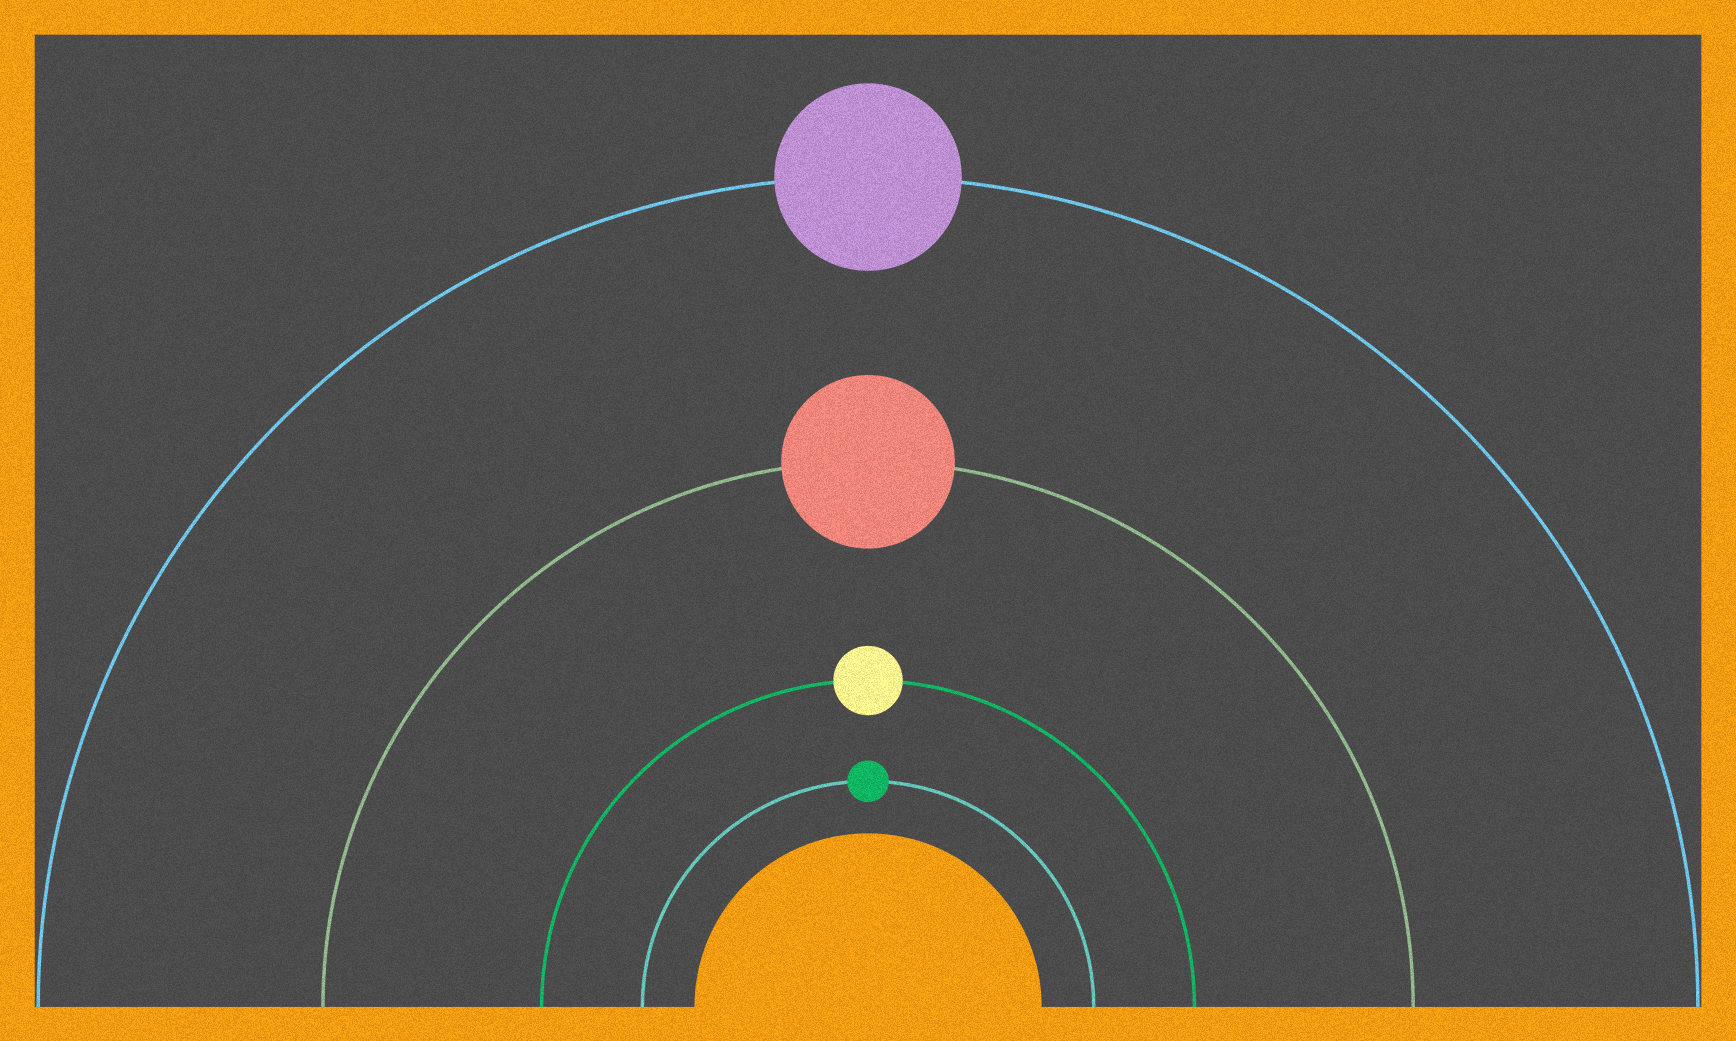

In [17]:
img = draw_solar_system()

svg.vis_graphic(img)

In [ ]:
#hide
from nbdev.export import *
notebook2script()